# **Installation & Define paths**

In [7]:
!pip -q install lpips pytorch-msssim

In [5]:
import numpy as np
import subprocess, os, sys, time, shutil, json, torch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ROOT = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/HiCForecast"
BASELINE_RUN = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729"

print("ROOT:", ROOT)
print("BASELINE:", BASELINE_RUN)

Mounted at /content/drive
ROOT: /content/drive/MyDrive/HiCForecast_Project_experiment_1/HiCForecast
BASELINE: /content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729


# **Create a NEW run folder for uncertainty**

In [6]:
RUN_ID = time.strftime("%Y%m%d_%H%M%S")
UNC_DIR = f"/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_uncertainty"
os.makedirs(UNC_DIR, exist_ok=True)

print("Uncertainty run folder:", UNC_DIR)

# Copy GT once (freeze ground truth)
shutil.copy(
    f"{BASELINE_RUN}/gt_chr19.npy",
    f"{UNC_DIR}/gt_chr19.npy"
)

# Save reproducibility metadata
meta = {
    "experiment": "uncertainty_ensemble",
    "run_id": RUN_ID,
    "torch": torch.__version__,
    "cuda": torch.cuda.is_available()
}
with open(f"{UNC_DIR}/run_meta.json", "w") as f:
    json.dump(meta, f, indent=2)


Uncertainty run folder: /content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_uncertainty


# **Run inference K times (ensemble)**

In [8]:
ROOT = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/HiCForecast"
MODEL_PATH = f"{ROOT}/trained_model/HiCForecast.pkl"
DATA_PATH  = f"{ROOT}/example_data/processed/input_patches/data_chr19_64.npy"
INDEX_PATH = f"{ROOT}/example_data/processed/input_patches/data_index_chr19_64.npy"
GT_PATH    = f"{ROOT}/example_data/processed/data_gt_chr19_64.npy"

TMP_DIR = "/content/_tmp_uncertainty"
os.makedirs(TMP_DIR, exist_ok=True)
out_prefix = f"{TMP_DIR}/pred_debug"

cmd = [
    sys.executable, f"{ROOT}/scripts/inference.py",
    "--max_HiC", "300",
    "--patch_size", "64",
    "--cut_off",
    "--model_path", MODEL_PATH,
    "--data_path", DATA_PATH,
    "--output_path", out_prefix,
    "--file_index_path", INDEX_PATH,
    "--no_batch_max",
    "--gt_path", GT_PATH,
]

env = os.environ.copy()
env["PYTHONPATH"] = ROOT + ":" + env.get("PYTHONPATH", "")

res = subprocess.run(cmd, cwd=ROOT, env=env, text=True, capture_output=True)
print("RETURN CODE:", res.returncode)
print("\n--- STDOUT ---\n", res.stdout[-2000:])
print("\n--- STDERR (TRACEBACK) ---\n", res.stderr[-4000:])

RETURN CODE: 0

--- STDOUT ---
 Executing predict.py
Performed cut off for prediction


--- STDERR (TRACEBACK) ---
 
100%|██████████| 490/490 [00:11<00:00, 41.77it/s]



In [9]:
K = 10
TMP_DIR = "/content/_tmp_uncertainty"
os.makedirs(TMP_DIR, exist_ok=True)

env = os.environ.copy()
env["PYTHONPATH"] = ROOT + ":" + env.get("PYTHONPATH", "")

samples = []

for i in range(K):
    out_prefix = f"{TMP_DIR}/pred_{i}"

    cmd = [
        sys.executable, f"{ROOT}/scripts/inference.py",
        "--max_HiC", "300",
        "--patch_size", "64",
        "--cut_off",
        "--model_path", MODEL_PATH,
        "--data_path", DATA_PATH,
        "--output_path", out_prefix,
        "--file_index_path", INDEX_PATH,
        "--no_batch_max",
        "--gt_path", GT_PATH,
    ]

    print(f"Running ensemble member {i+1}/{K} ...")
    res = subprocess.run(cmd, cwd=ROOT, env=env, text=True, capture_output=True)

    if res.returncode != 0:
        print("FAILED member:", i)
        print("STDOUT:\n", res.stdout[-1500:])
        print("STDERR:\n", res.stderr[-3000:])
        raise RuntimeError("Inference failed")

    pred = np.load(out_prefix + ".npy").astype(np.float32)  # (3, N, N)
    samples.append(pred)
    os.remove(out_prefix + ".npy")

samples = np.stack(samples, axis=0)  # (K, 3, N, N)
pred_mean = samples.mean(axis=0)
pred_std  = samples.std(axis=0)

print("Done.")
print("samples:", samples.shape, "mean:", pred_mean.shape, "std:", pred_std.shape)

Running ensemble member 1/10 ...
Running ensemble member 2/10 ...
Running ensemble member 3/10 ...
Running ensemble member 4/10 ...
Running ensemble member 5/10 ...
Running ensemble member 6/10 ...
Running ensemble member 7/10 ...
Running ensemble member 8/10 ...
Running ensemble member 9/10 ...
Running ensemble member 10/10 ...
Done.
samples: (10, 3, 1534, 1534) mean: (3, 1534, 1534) std: (3, 1534, 1534)


# **Compute mean + uncertainty**

In [13]:
RUN_ID = time.strftime("%Y%m%d_%H%M%S")
UNC_DIR = f"/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty"
os.makedirs(UNC_DIR, exist_ok=True)

np.save(f"{UNC_DIR}/pred_uncertainty_mean.npy", pred_mean)
np.save(f"{UNC_DIR}/pred_uncertainty_std.npy", pred_std)

# Copy GT into this run folder
shutil.copy(GT_PATH, f"{UNC_DIR}/gt_chr19.npy")

# Save metadata
with open(f"{UNC_DIR}/run_meta.json", "w") as f:
    json.dump({
        "run_id": RUN_ID,
        "experiment": "uncertainty_ensemble",
        "K": K,
        "torch": torch.__version__,
        "cuda_available": torch.cuda.is_available()
    }, f, indent=2)

print("Saved uncertainty run to:", UNC_DIR)

Saved uncertainty run to: /content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty


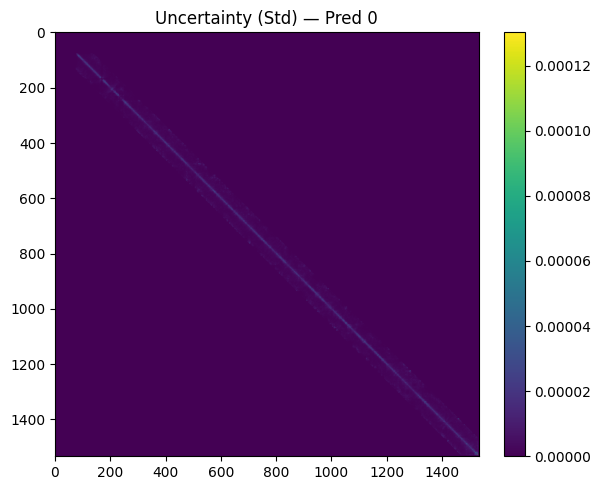

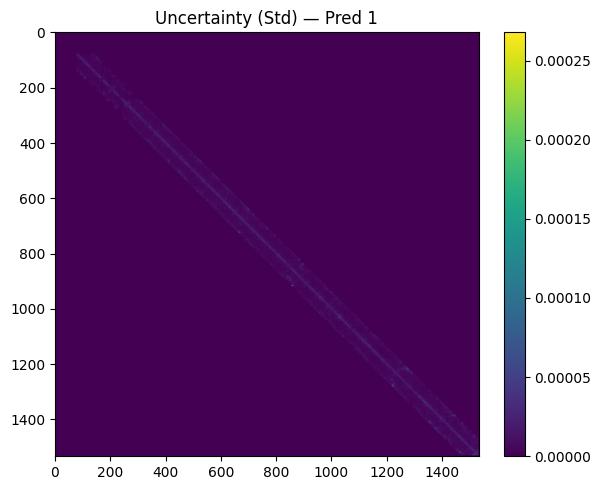

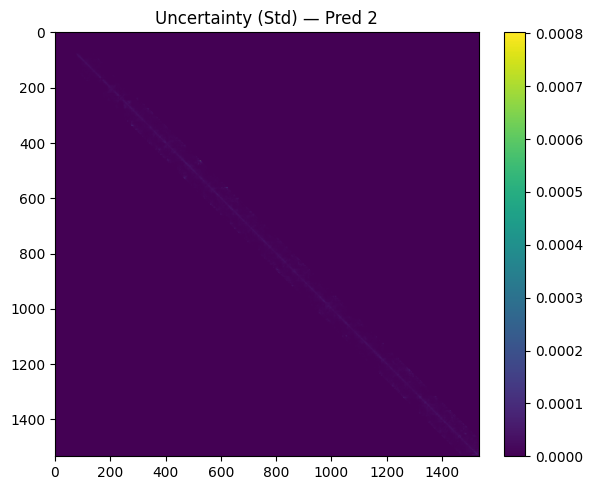

In [11]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.figure(figsize=(6,5))
    plt.imshow(pred_std[i])
    plt.colorbar(fraction=0.046)
    plt.title(f"Uncertainty (Std) — Pred {i}")
    plt.tight_layout()
    plt.savefig(f"{UNC_DIR}/fig_uncertainty_pred{i}.png", dpi=200)
    plt.show()

# **Sanity check**

In [18]:
UNC_DIR = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty"
BASELINE_RUN = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729"

pred_mean = np.load(f"{UNC_DIR}/pred_uncertainty_mean.npy")
pred_std  = np.load(f"{UNC_DIR}/pred_uncertainty_std.npy")

print("pred_mean:", pred_mean.shape, "pred_std:", pred_std.shape)
print("UNC std stats -> min/mean/max:", float(pred_std.min()), float(pred_std.mean()), float(pred_std.max()))


pred_mean: (3, 1534, 1534) pred_std: (3, 1534, 1534)
UNC std stats -> min/mean/max: 0.0 4.584603630064521e-07 0.0008017897489480674


# **Evaluate uncertainty mean prediction**

pred_mean: (3, 1534, 1534) gt: (6, 1534, 1534)


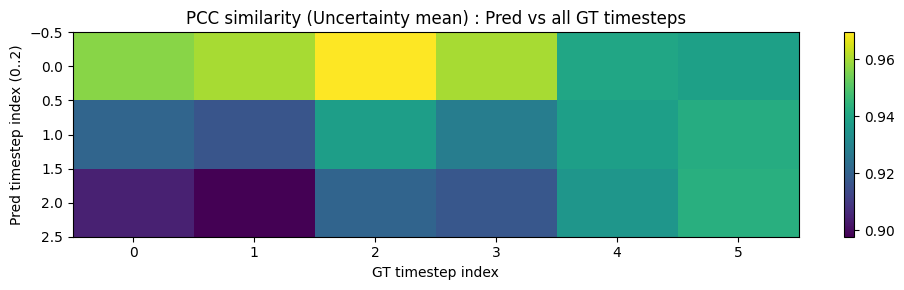

AUTO best GT match: [2, 5, 5]
Saved: /content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty/metrics_uncertainty_auto.csv
{'pred_idx': 0, 'matched_gt_idx': 2, 'PCC_full': 0.9695377368292363, 'SSIM_full': 0.9877454618409691, 'PSNR_full': 47.55771606833821, 'MAE_full': 0.9198507057178675, 'MSE_full': 12.440922256090628, 'PCC_patch': 0.9755181625307093, 'SSIM_patch': 0.9322884161669664, 'PSNR_patch': 28.374904314468537, 'num_patches_used': 24}
{'pred_idx': 1, 'matched_gt_idx': 5, 'PCC_full': 0.9422211349375633, 'SSIM_full': 0.960876797794174, 'PSNR_full': 40.438132830395105, 'MAE_full': 1.105130358004094, 'MSE_full': 18.388224641744575, 'PCC_patch': 0.9378989839140536, 'SSIM_patch': 0.7690656449245394, 'PSNR_patch': 23.72663643084015, 'num_patches_used': 24}
{'pred_idx': 2, 'matched_gt_idx': 5, 'PCC_full': 0.9431417115432394, 'SSIM_full': 0.9603925691492137, 'PSNR_full': 40.75924254272166, 'MAE_full': 1.1048137282159474, 'MSE_full': 17.0776783467547

In [20]:
# Load data
pred_mean = np.load(f"{UNC_DIR}/pred_uncertainty_mean.npy").astype(np.float32)  # (3,N,N)
pred_std  = np.load(f"{UNC_DIR}/pred_uncertainty_std.npy").astype(np.float32)
gt        = np.load(f"{UNC_DIR}/gt_chr19.npy")  # (T,N,N)

print("pred_mean:", pred_mean.shape, "gt:", gt.shape)

def pcc(a, b, eps=1e-12):
    a = a.astype(np.float64).ravel()
    b = b.astype(np.float64).ravel()
    a -= a.mean(); b -= b.mean()
    return float((a @ b) / (np.sqrt((a @ a) + eps) * np.sqrt((b @ b) + eps)))

def diagonal_patches(M, patch=60, stride=60):
    N = M.shape[0]
    out = []
    for s in range(0, N - patch + 1, stride):
        p = M[s:s+patch, s:s+patch]
        if np.any(p):
            out.append(p)
    return out

def avg_patch_metrics(X, Y, patch=60, stride=60):
    Xp = diagonal_patches(X, patch=patch, stride=stride)
    Yp = diagonal_patches(Y, patch=patch, stride=stride)
    m = min(len(Xp), len(Yp))
    if m == 0:
        return {"PCC_patch": np.nan, "SSIM_patch": np.nan, "PSNR_patch": np.nan, "num_patches_used": 0}
    pccs, ssims, psnrs = [], [], []
    for i in range(m):
        a, b = Xp[i], Yp[i]
        dr = float(a.max() - a.min() + 1e-12)
        pccs.append(pcc(a, b))
        ssims.append(float(ssim(a, b, data_range=dr)))
        psnrs.append(float(psnr(a, b, data_range=dr)))
    return {
        "PCC_patch": float(np.mean(pccs)),
        "SSIM_patch": float(np.mean(ssims)),
        "PSNR_patch": float(np.mean(psnrs)),
        "num_patches_used": m
    }

# -------------------------
# (A) AUTO-MATCH heatmap
# -------------------------
T = gt.shape[0]
sim = np.zeros((pred_mean.shape[0], T), dtype=float)
for i in range(pred_mean.shape[0]):
    for t in range(T):
        sim[i, t] = pcc(pred_mean[i], gt[t])

plt.figure(figsize=(10,3))
plt.imshow(sim, aspect="auto")
plt.colorbar()
plt.xlabel("GT timestep index")
plt.ylabel("Pred timestep index (0..2)")
plt.title("PCC similarity (Uncertainty mean) : Pred vs all GT timesteps")
plt.tight_layout()
plt.savefig(f"{UNC_DIR}/fig_similarity_heatmap_uncertainty.png", dpi=200)
plt.show()

best_auto = sim.argmax(axis=1).astype(int)
print("AUTO best GT match:", best_auto.tolist())

def compute_metrics(pred, matched_idx_list, out_csv_path):
    rows = []
    for i in range(pred.shape[0]):
        t = int(matched_idx_list[i])
        X, Y = gt[t], pred[i]
        dr = float(X.max() - X.min() + 1e-12)
        row = {
            "pred_idx": i,
            "matched_gt_idx": t,
            "PCC_full": pcc(X, Y),
            "SSIM_full": float(ssim(X, Y, data_range=dr)),
            "PSNR_full": float(psnr(X, Y, data_range=dr)),
            "MAE_full": float(np.mean(np.abs(X - Y))),
            "MSE_full": float(np.mean((X - Y) ** 2)),
        }
        row.update(avg_patch_metrics(X, Y, patch=60, stride=60))
        rows.append(row)

    # write csv (no pandas needed)
    with open(out_csv_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        w.writeheader()
        w.writerows(rows)

    print("Saved:", out_csv_path)
    for r in rows:
        print(r)

# AUTO metrics
compute_metrics(pred_mean, best_auto, f"{UNC_DIR}/metrics_uncertainty_auto.csv")

# -------------------------
# (B) FIXED-MATCH (use baseline matched_gt_idx)
# -------------------------
base_csv_candidates = glob.glob(f"{BASELINE_RUN}/metrics_baseline*.csv")
assert len(base_csv_candidates) > 0, f"Could not find baseline metrics CSV in {BASELINE_RUN}"
base_csv = base_csv_candidates[0]
print("Using baseline metrics:", base_csv)

base_map = {}
with open(base_csv, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        base_map[int(row["pred_idx"])] = int(row["matched_gt_idx"])

fixed = [base_map[i] for i in range(pred_mean.shape[0])]
print("FIXED GT match (from baseline):", fixed)

compute_metrics(pred_mean, fixed, f"{UNC_DIR}/metrics_uncertainty_fixed.csv")

# **Create a Baseline vs Uncertainty delta table**

In [21]:
base_csv = glob.glob(f"{BASELINE_RUN}/metrics_baseline*.csv")[0]
unc_csv  = f"{UNC_DIR}/metrics_uncertainty_fixed.csv"

def read_csv_as_dict(path, key="pred_idx"):
    rows = {}
    with open(path, "r") as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows[int(r[key])] = r
    return rows

base_rows = read_csv_as_dict(base_csv)
unc_rows  = read_csv_as_dict(unc_csv)

fields = [
    "PCC_full","SSIM_full","PSNR_full","MAE_full","MSE_full",
    "PCC_patch","SSIM_patch","PSNR_patch"
]

out_path = f"{UNC_DIR}/metrics_delta_uncertainty_fixed.csv"
out_rows = []

for i in sorted(base_rows.keys()):
    b = base_rows[i]
    u = unc_rows[i]
    out = {
        "pred_idx": i,
        "matched_gt_idx_baseline": b["matched_gt_idx"],
        "matched_gt_idx_uncert_fixed": u["matched_gt_idx"],
    }
    for k in fields:
        bv = float(b[k]); uv = float(u[k])
        out[f"baseline_{k}"] = bv
        out[f"uncert_{k}"] = uv
        out[f"delta_{k}"] = uv - bv
    out_rows.append(out)

with open(out_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(out_rows[0].keys()))
    w.writeheader()
    w.writerows(out_rows)

print("Saved:", out_path)
for r in out_rows:
    print(r)

Saved: /content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty/metrics_delta_uncertainty_fixed.csv
{'pred_idx': 0, 'matched_gt_idx_baseline': '2', 'matched_gt_idx_uncert_fixed': '2', 'baseline_PCC_full': 0.9695377377894626, 'uncert_PCC_full': 0.9695377368292363, 'delta_PCC_full': -9.602263428831748e-10, 'baseline_SSIM_full': 0.9877454618726942, 'uncert_SSIM_full': 0.9877454618409691, 'delta_SSIM_full': -3.17250670178737e-11, 'baseline_PSNR_full': 47.557716282219005, 'uncert_PSNR_full': 47.55771606833821, 'delta_PSNR_full': -2.138807957408062e-07, 'baseline_MAE_full': 0.9198506990244153, 'uncert_MAE_full': 0.9198507057178675, 'delta_MAE_full': 6.693452236916642e-09, 'baseline_MSE_full': 12.440921643401667, 'uncert_MSE_full': 12.440922256090628, 'delta_MSE_full': 6.126889608992769e-07, 'baseline_PCC_patch': 0.9755181630741928, 'uncert_PCC_patch': 0.9755181625307093, 'delta_PCC_patch': -5.434834804418642e-10, 'baseline_SSIM_patch': 0.932288416635161

# **Combined figures (GT / Mean Pred / |Diff| / Uncertainty)**

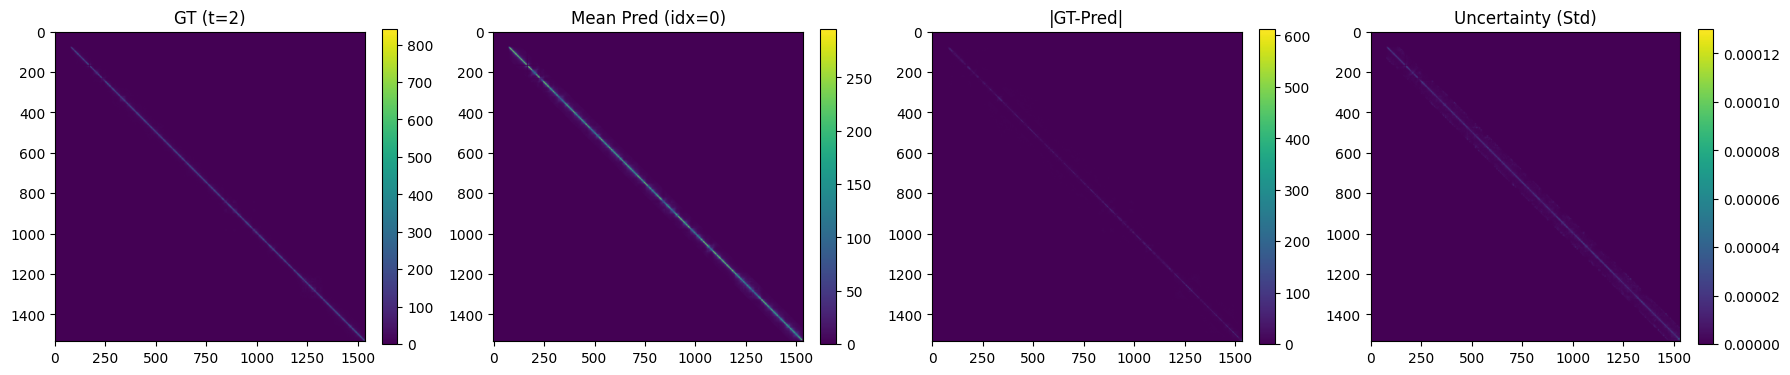

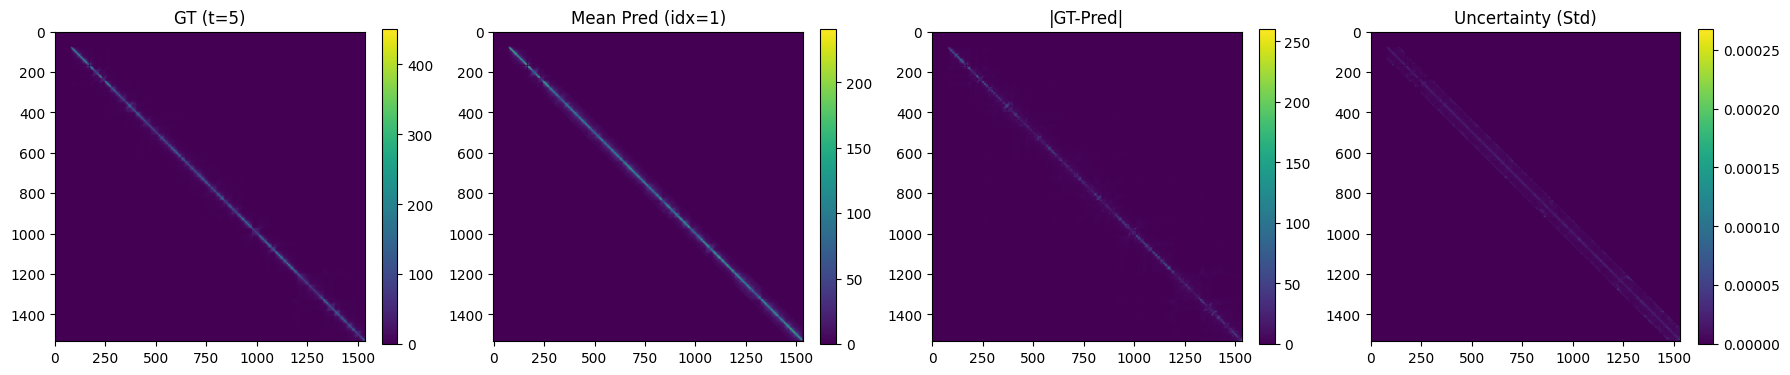

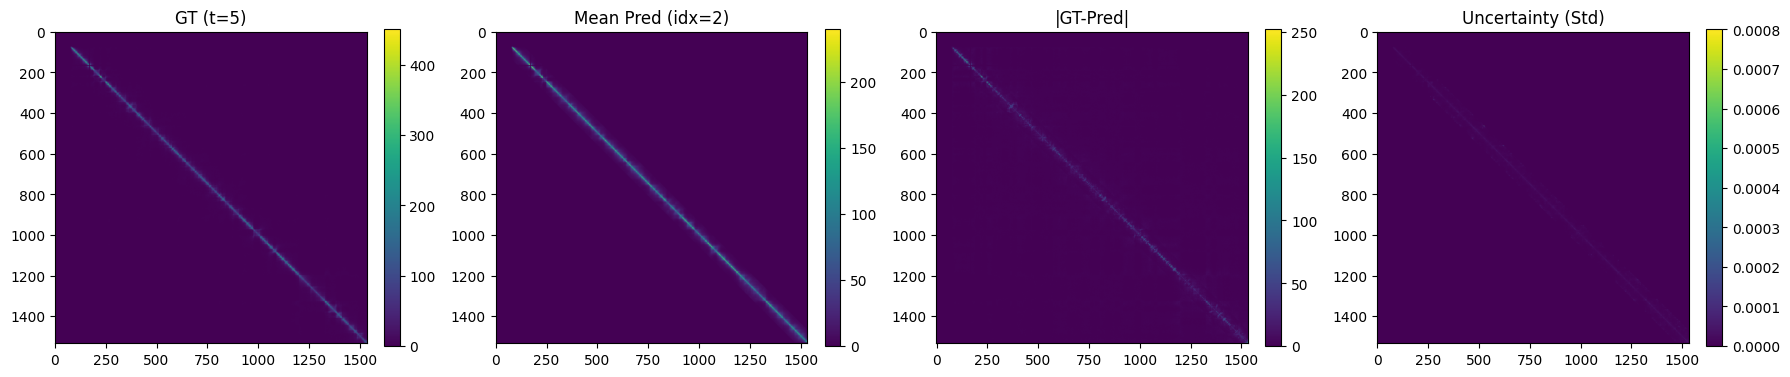

Saved combined figures to: /content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty
total 110M
-rw------- 1 root root 290K Jan 18 23:16 fig_gt_pred_diff_uncert_pred0_gt2.png
-rw------- 1 root root 393K Jan 18 23:16 fig_gt_pred_diff_uncert_pred1_gt5.png
-rw------- 1 root root 473K Jan 18 23:17 fig_gt_pred_diff_uncert_pred2_gt5.png
-rw------- 1 root root  57K Jan 18 23:14 fig_similarity_heatmap_uncertainty.png
-rw------- 1 root root 148K Jan 18 22:57 fig_uncertainty_pred0.png
-rw------- 1 root root 148K Jan 18 22:57 fig_uncertainty_pred1.png
-rw------- 1 root root 120K Jan 18 22:57 fig_uncertainty_pred2.png
-rw------- 1 root root  54M Jan 18 23:04 gt_chr19.npy
-rw------- 1 root root 2.0K Jan 18 23:15 metrics_delta_uncertainty_fixed.csv
-rw------- 1 root root  596 Jan 18 23:14 metrics_uncertainty_auto.csv
-rw------- 1 root root  596 Jan 18 23:14 metrics_uncertainty_fixed.csv
-rw------- 1 root root  27M Jan 18 23:04 pred_uncertainty_mean.npy
-rw------

In [22]:
pred_mean = np.load(f"{UNC_DIR}/pred_uncertainty_mean.npy")
pred_std  = np.load(f"{UNC_DIR}/pred_uncertainty_std.npy")
gt        = np.load(f"{UNC_DIR}/gt_chr19.npy")

# Use FIXED mapping for fair before/after visuals
base_csv = glob.glob(f"{BASELINE_RUN}/metrics_baseline*.csv")[0]
fixed = [0,0,0]
with open(base_csv, "r") as f:
    reader = csv.DictReader(f)
    for r in reader:
        fixed[int(r["pred_idx"])] = int(r["matched_gt_idx"])

for i in range(3):
    t = fixed[i]
    X = gt[t]
    Y = pred_mean[i]
    D = np.abs(X - Y)
    U = pred_std[i]

    plt.figure(figsize=(18,4))
    plt.subplot(1,4,1); plt.title(f"GT (t={t})"); plt.imshow(X); plt.colorbar(fraction=0.046)
    plt.subplot(1,4,2); plt.title(f"Mean Pred (idx={i})"); plt.imshow(Y); plt.colorbar(fraction=0.046)
    plt.subplot(1,4,3); plt.title("|GT-Pred|"); plt.imshow(D); plt.colorbar(fraction=0.046)
    plt.subplot(1,4,4); plt.title("Uncertainty (Std)"); plt.imshow(U); plt.colorbar(fraction=0.046)
    plt.tight_layout()
    plt.savefig(f"{UNC_DIR}/fig_gt_pred_diff_uncert_pred{i}_gt{t}.png", dpi=200)
    plt.show()

print("Saved combined figures to:", UNC_DIR)
!ls -lh "$UNC_DIR"